In [118]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"

from itertools import repeat, chain
import warnings

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_blobs
from sklearn.metrics import (
    davies_bouldin_score,
    silhouette_score,
)
from yellowbrick.cluster import KElbowVisualizer

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

In [5]:
seed = 12
rs = np.random.RandomState(seed)

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (15, 12)

## Fish Data

In [203]:
species = np.array(
    list(
        chain(
            repeat("Bream", 34),
            repeat("Roach", 20),
            repeat("Smelt", 14),
            repeat("Pike", 17),
        )
    )
)
np.unique(species, return_counts=True)

(array(['Bream', 'Pike', 'Roach', 'Smelt'], dtype='<U5'),
 array([34, 17, 20, 14]))

In [204]:
fishes = pd.read_csv(
    "../Week_2_Data/fish.csv",
    header=None,
    index_col=False,
    skiprows=1,
    usecols=range(1, 7),
)
fishes.shape

(85, 6)

In [390]:
fishes.head(5)

,1,2,3,4,5,6
0,242.0,23.2,25.4,30.0,38.4,13.4
1,290.0,24.0,26.3,31.2,40.0,13.8
2,340.0,23.9,26.5,31.1,39.8,15.1
3,363.0,26.3,29.0,33.5,38.0,13.3
4,430.0,26.5,29.0,34.0,36.6,15.1


In [206]:
# Sklearn's kmeans only accepts numerical data
fishes.dtypes

1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
dtype: object

In [207]:
# Pipeline
pipeline_fish = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=4, n_init=10, random_state=seed)),
    ]
)

# Fit the pipeline to samples
pipeline_fish.fit(fishes)

# Calculate the cluster labels: labels
pipeline_fish["kmeans"].labels_

Pipeline(steps=[('scaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=4, n_init=10, random_state=12))])

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [208]:
# Create crosstab
ct = pd.crosstab(
    pipeline_fish["kmeans"].labels_, species, rownames=["labels"], colnames=["species"]
)
ct

species,Bream,Pike,Roach,Smelt
labels,,,,
0,0,17,0,0
1,1,0,19,1
2,33,0,1,0
3,0,0,0,13


## Price Movements Data

In [209]:
movements = pd.read_csv("../Week_2_Data/movements.csv", index_col=0)
movements.shape

(60, 963)

In [389]:
movements.head(5)

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,-0.709999,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998


In [211]:
# The normalizer is stateless, and so it behaves the same way at training time, validation time, or the test time
pipeline = Pipeline(
    [
        ("normalizer", Normalizer(norm="l2")),
        ("kmeans", KMeans(n_clusters=10, n_init=10, random_state=seed)),
    ]
)

# Fit pipeline to the daily price movements
pipeline.fit(movements.values)

pipeline["kmeans"].labels_

Pipeline(steps=[('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=10, n_init=10, random_state=12))])

array([6, 7, 1, 7, 9, 7, 4, 1, 5, 8, 2, 6, 2, 5, 6, 7, 7, 1, 7, 4, 1, 1,
       6, 4, 6, 3, 7, 3, 8, 9, 1, 8, 5, 6, 1, 5, 9, 4, 8, 3, 3, 8, 4, 4,
       2, 1, 4, 4, 1, 4, 6, 6, 4, 0, 3, 7, 3, 2, 5, 5], dtype=int32)

In [212]:
# Examine the cluster labels
for label, count in zip(*np.unique(pipeline["kmeans"].labels_, return_counts=True)):
    print(f"Cluster {label} Count: {count}")

Cluster 0 Count: 1
Cluster 1 Count: 9
Cluster 2 Count: 4
Cluster 3 Count: 6
Cluster 4 Count: 10
Cluster 5 Count: 6
Cluster 6 Count: 8
Cluster 7 Count: 8
Cluster 8 Count: 5
Cluster 9 Count: 3


Make predictions for each training example:

In [213]:
labels = pipeline["kmeans"].predict(movements.values)

df = pd.DataFrame({"labels": labels, "companies": movements.index.values})

print(df.sort_values("labels"))

    labels                           companies
53       0                       Valero Energy
45       1                                Sony
17       1                     Google/Alphabet
48       1                              Toyota
21       1                               Honda
30       1                          MasterCard
7        1                               Canon
20       1                          Home Depot
2        1                              Amazon
34       1                          Mitsubishi
8        2                         Caterpillar
44       2                        Schlumberger
12       2                             Chevron
57       2                               Exxon
10       2                      ConocoPhillips
40       3                      Procter Gamble
25       3                   Johnson & Johnson
54       3                            Walgreen
56       3                            Wal-Mart
27       3                      Kimberly-Clark
39       3   

## Iris Data

In [218]:
iris = pd.read_csv("../Week_2_Data/iris.csv", index_col=0)
iris.shape

(150, 5)

In [391]:
iris.head(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


We will perform PCA to see if the data matrix with only the numerical features, which is 4-dimensional, is intrinsically lower-dimensional. For higher-dimensional data, the DBSCAN algorithm may suffer from the "curse of dimensionality." In addition, reducing the dimensionality can help with visualizing the results of DBSCAN. 

Note: Because of PCA, the plots and results of this homework will be different from the class lecture notebook, which uses two features in the original vector space. However, it is just a difference in methodology since combining PCA and clustering is also a valid approach.

### PCA

In [330]:
# Select the numerical columns
pca_df = StandardScaler().fit_transform(iris.iloc[:, :4])

pca = PCA(n_components=4, whiten=True)

# Fit the PCA instance to the scaled samples
pca.fit(pca_df)

PCA(n_components=4, whiten=True)

Next, we create the scree plot to examine the percentage of variance explained by each principal component:

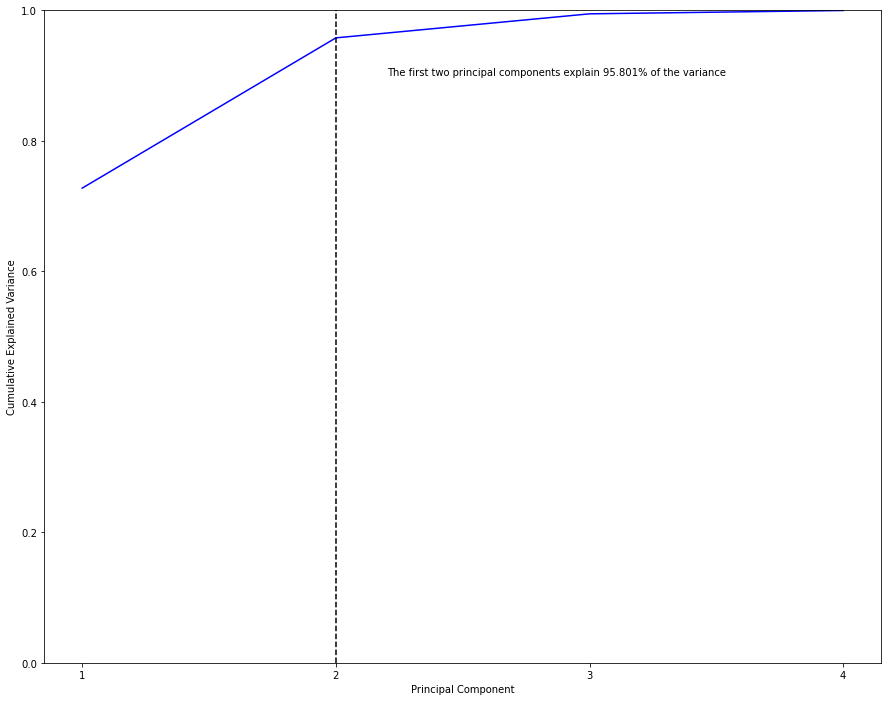

In [331]:
# Cumulative explained variance
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)
pc_indices = range(1, pca.n_components_ + 1)

plt.plot(pc_indices, cum_exp_var, color="blue")
plt.ylim(0, 1)
plt.xticks(pc_indices)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.axvline(x=2, color="black", linestyle="--")
# Add a label at x = 1 for the value of y
plt.text(
    2.2,
    0.9,
    f"The first two principal components explain {round(cum_exp_var[1] * 100, 4)}% of the variance",
    color="black",
)
plt.show();

As can be seen, the first two principal components are enough to capture over 95% of the variance in the data. Therefore, we will proceed to apply DBSCAN to the two-dimensional data matrix formed by the first and second principal components. For completeness, we will create a pipeline that includes pca as the first step. Before we proceed, we can visualize the first two components and their associated species labels.

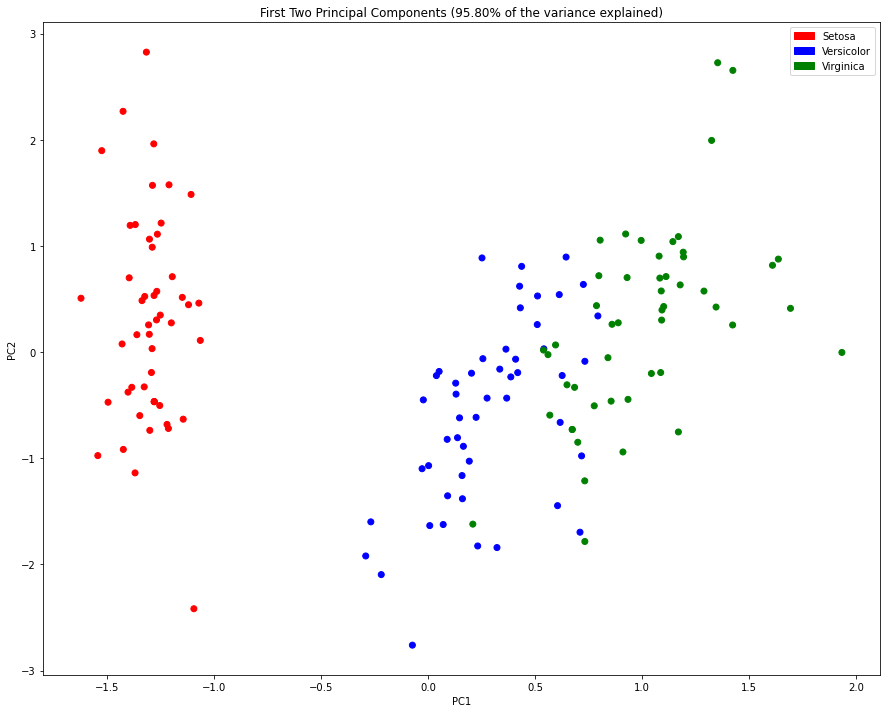

In [346]:
plot_df = pd.DataFrame(pca.transform(pca_df)[:, :2], columns=["PC1", "PC2"])
plot_df["Species"] = iris["Species"].values

# Plot the 2 principal components with the species labels
red_patch = mpatches.Patch(color="red", label="Setosa")
blue_patch = mpatches.Patch(color="blue", label="Versicolor")
green_patch = mpatches.Patch(color="green", label="Virginica")
plt.scatter(
    plot_df["PC1"],
    plot_df["PC2"],
    c=plot_df["Species"].map(
        {"Iris-setosa": "red", "Iris-versicolor": "blue", "Iris-virginica": "green"}
    ),
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(
    f"First Two Principal Components ({cum_exp_var[1] * 100:.2f}% of the variance explained)"
)
plt.legend(handles=[red_patch, blue_patch, green_patch])
plt.show();

This is the representation of a four-dimensional data matrix in the two-dimensional space (x-y plane) plus a third dimension represented by the colors.

### DBSCAN

Once PCA is performed, the two-dimensional data matrix will be standardized (`whiten=True`), and so there is no need to standardize again to prepare for DBSCAN:

In [341]:
for i in range(4):
    print(f"The mean of PC{i + 1} is {round(np.mean(pca.transform(pca_df)[:, i]), 4)}")
    print(
        f"The variance of PC{i + 1} is {round(np.var(pca.transform(pca_df)[:, i]), 4)}\n"
    )

The mean of PC1 is 0.0
The variance of PC1 is 0.9933

The mean of PC2 is 0.0
The variance of PC2 is 0.9933

The mean of PC3 is 0.0
The variance of PC3 is 0.9933

The mean of PC4 is -0.0
The variance of PC4 is 0.9933



In [342]:
# Pipeline
pipeline_iris = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2, whiten=True)),
        ("dbscan", DBSCAN(eps=0.5, min_samples=5, metric="euclidean", n_jobs=-1)),
    ]
)

# Fit the pipeline to samples and predict the cluster labels
iris_labels = pipeline_iris.fit_predict(iris.iloc[:, :4])

iris_labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

We can plot the predicted cluster labels with the species labels on the same plot to examine the clustering results. Does the clustering algorithm produce labels that are generally consistent with the species labels or are there some within species variability (i.e. same species label but different cluster label)?

Note: we will continue to use the first two principal components to plot the data.

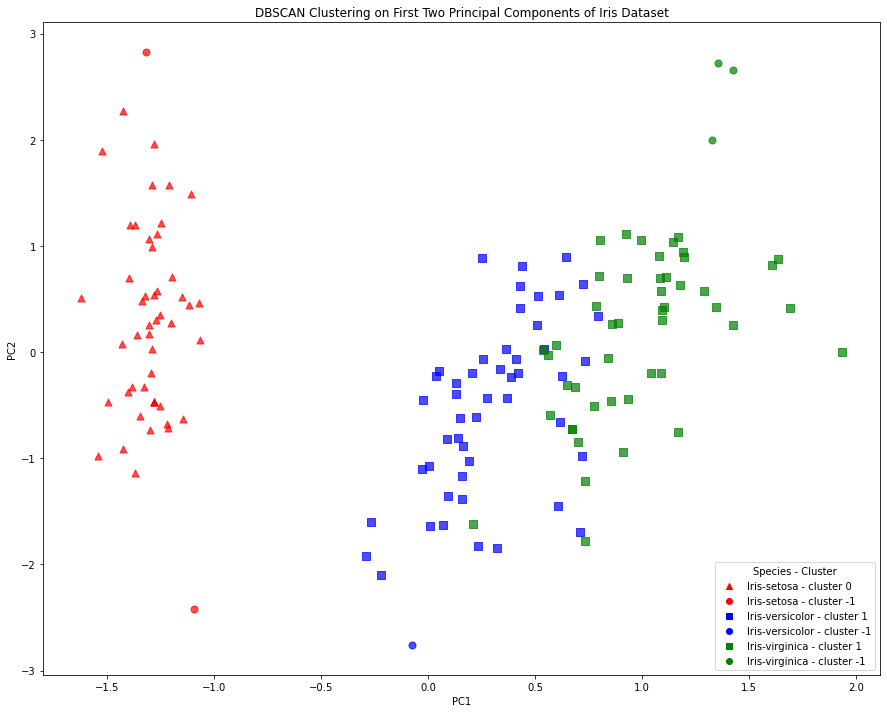

In [387]:
plot_df["Cluster Labels"] = iris_labels

# Create a dictionary to map species names to colors
species_colors = {
    "Iris-setosa": "red",
    "Iris-versicolor": "blue",
    "Iris-virginica": "green",
}

# Create a dictionary to map cluster labels to shapes
cluster_shapes = {-1: "o", 0: "^", 1: "s"}

# Create an empty figure
fig, ax = plt.subplots()

# Iterate through the dataframe
for i, row in plot_df.iterrows():
    ax.scatter(
        row["PC1"],
        row["PC2"],
        c=species_colors[row["Species"]],
        marker=cluster_shapes[row["Cluster Labels"]],
        alpha=0.7,
        s=50,
    )


# Create the legend handles
handles = [
    plt.scatter(
        [],
        [],
        c=species_colors[s],
        marker=cluster_shapes[c],
        label=f"{s} - cluster {c}",
    )
    for s, c in plot_df[["Species", "Cluster Labels"]].drop_duplicates().values
]  # The drop_duplicates() method removes duplicate rows, so that each species-cluster combination is only represented once

# Create the legend
plt.legend(handles=handles, title="Species - Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("DBSCAN Clustering on First Two Principal Components of Iris Dataset")

# Show the plot
plt.show();

As can be seen, there is indeed within species variability; for each color (species label), there are more than one shape (cluster label), indicating that the DBSCAN clustering algorithm produced cluster labels that do not coincide with the species labels exactly. Therefore, clustering can be viewed as another way to segment the data in addition to using the species labels. 

## Anisotropically Distributed Clusters

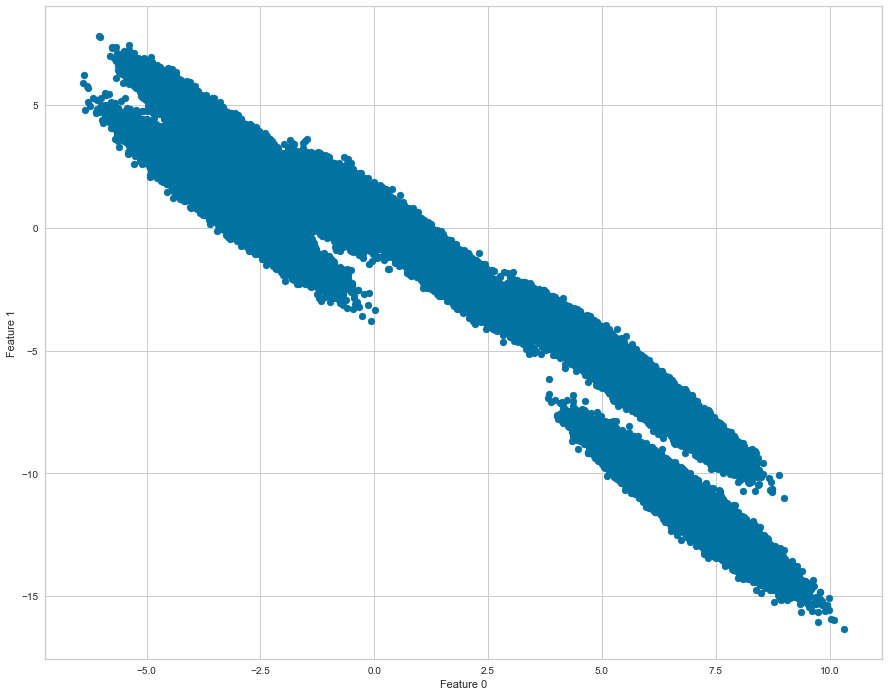

In [6]:
# Generate some random cluster data
X, y = make_blobs(random_state=170, n_samples=1000000, centers=5)
rng = np.random.RandomState(74)
# Transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X = np.dot(X, transformation)
# Plot
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show();

1. Apply both k-means and DBSCAN for the randomly generated cluster data above.
2. Plot the results for both algorithms by highlighting clusters in different colors.
3. Interpret your results. If you observe a difference in the output of two algorithms, write up a paragraph containing your examination as why one algorithm performed better than the other.


## Internal Evaluation Index

We will evaluate the performance of clustering techniques using two indices:

* The Calinski-Harabasz Index, which is also known as the Variance Ratio Criterion. The higher the score, the better the model defines the clusters.

* The Davies-Bouldin Index, which signifies the average similarity between clusters. Similarity in this context is a measure that compares the distance between clusters with the size of the clusters themselves.

These are called internal evaluation methods that use only the information within the data set to evaluate the quality of a clustering solution. Both of these indices do not require knowledge of the ground-truth label. The `make_blobs` function, however, does returns a ground truth label `y`, and there exists indices that can be used to evaluate the algorithm's performance when we have knowledge of the ground truth labels. For this assignment, however, we will practice applying clustering techniques without the ground truth label, which is a more realistic scenario.

### Calinski-Harabasz Index

For a set of data $E$ of size $n_E$ which has been clustered into $k$ clusters, the Calinski-Harabasz score $s$ is defined as the ratio of the between-clusters dispersion mean and the within-cluster dispersion:
$$
s=\frac{\operatorname{tr}\left(B_k\right)}{\operatorname{tr}\left(W_k\right)} \times \frac{n_E-k}{k-1}
$$
where $\operatorname{tr}\left(B_k\right)$ is trace of the between group dispersion matrix and $\operatorname{tr}\left(W_k\right)$ is the trace of the within-cluster dispersion matrix defined by:
$$
\begin{aligned}
& W_k=\sum_{q=1}^k \sum_{x \in C_q}\left(x-c_q\right)\left(x-c_q\right)^T \\
& B_k=\sum_{q=1}^k n_q\left(c_q-c_E\right)\left(c_q-c_E\right)^T
\end{aligned}
$$
where 

* $C_q$ is the set of points in cluster $q$
* $c_q$ is the center of cluster $q$
* $c_E$ is the center of entire dataset $E$ (e.g. average of all training examples)
* $n_q$ is the number of points in cluster $q$

The range of the Calinski-Harabasz Index is theoretically from 0 to infinity where a value of 0 indicates that the clustering solution is not useful, and the higher the value, the better the clustering solution is considered to be. However, in practice, the CH Index values are typically between 0 and $10^{4}$.

### Davies-Bouldin Index

The index is defined as the **average similarity** between each cluster $C_i$ for $i=1, \ldots, k$ and its most similar one $C_j$. In the context of this index, similarity is defined as a measure $R_{i j}$ that trades off:

- $s_i$, the average distance between each point of cluster $i$ and the centroid of that cluster - also know as cluster diameter.
- $d_{i j}$, the distance between cluster centroids $i$ and $j$.
  
A simple choice to construct $R_{i j}$ so that it is nonnegative and symmetric is:
$$
R_{i j}=\frac{s_i+s_j}{d_{i j}}
$$
Then the Davies-Bouldin index is defined as:
$$
D B=\frac{1}{k} \sum_{i=1}^k \max _{i \neq j} R_{i j}
$$

These conditions constrain the index to be symmetric and non-negative. Due to the way it is defined, as a function of the ratio of the within cluster scatter, to the between cluster separation, a lower value will mean that the clustering is better.

## K-Means

The data is two-dimensional and numerical, so the only preprocessing needed is to standardize the features. We will select the number of clusters based on the above-mentioned indices:

In [7]:
# Standardize the data once so that we can compare the clustering algorithms
X_scaled = StandardScaler().fit_transform(X)

# Define range for number of clusters
k_range = range(2, 15)

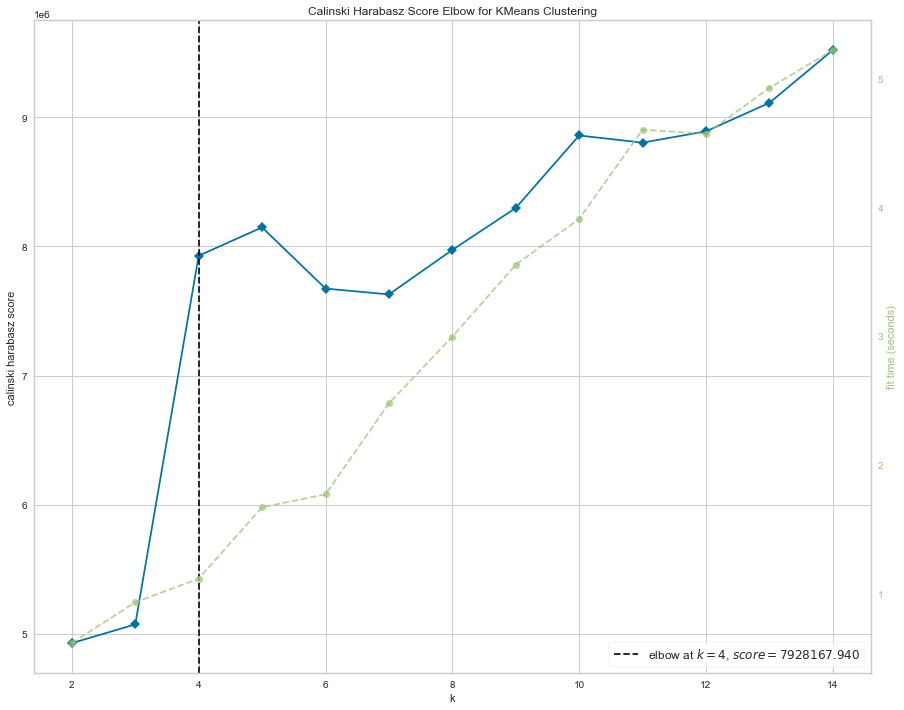

In [36]:
model = KMeans(n_init=10, random_state=rs)

visualizer = KElbowVisualizer(
    model=model, k=k_range, metric="calinski_harabasz", timings=True
)
visualizer.fit(X_scaled)
visualizer.show();

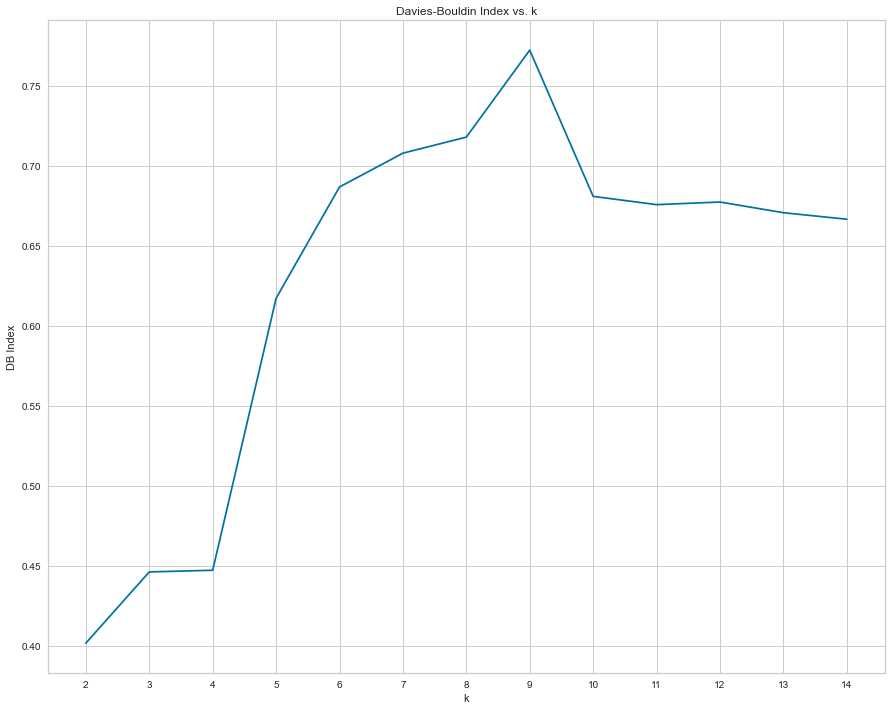

In [39]:
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=rs)
    kmeans.fit(X_scaled)
    db_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

plt.plot(k_range, db_scores)
plt.xlabel("k")
plt.ylabel("DB Index")
plt.title("Davies-Bouldin Index vs. k")
plt.xticks(k_range)
plt.show();

### Results for K-Means

The two evaluation indices differ in turns of the **optimal** number of clusters:

* Calinski-Harabasz Index: $k=4$

* Davies-Bouldin Index: $k=2, 3, 4$ have similar values, but $k=2$ has the smallest value.

When different internal evaluation lead to divergent results, it is common to try to reconcile these differences using external information--- considerations of problem domain, consideration of how the output of clustering will be used by down-stream analysis, visual inspection. For the purpose of this assignment, we will select $k=3$ as a compromise between the **optimal** numbers of clusters recommended by the two evaluation indices.  

In [43]:
# Pipeline for KMeans
pipeline_kmeans = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("kmeans", KMeans(n_clusters=3, n_init=20, random_state=rs)),
    ]
)

# Fit the pipeline to samples and predict the cluster labels
labels_kmeans = pipeline_kmeans.fit_predict(X)

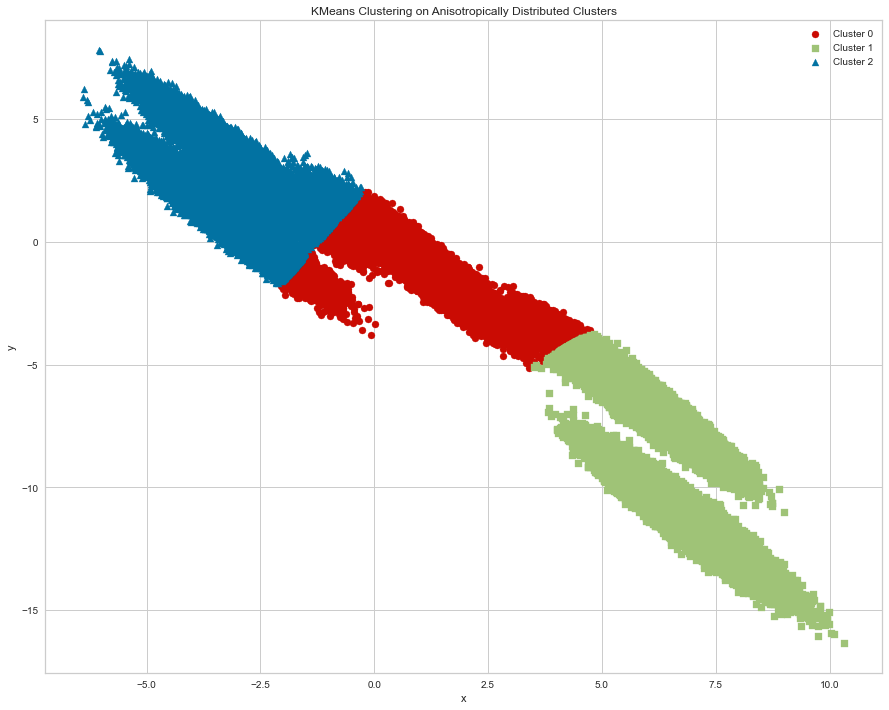

In [47]:
# Data for plotting
x = X[:, 0]
y = X[:, 1]
c_kmeans = labels_kmeans

# Define a color map and markers for each cluster
colors = ["r", "g", "b"]
markers = ["o", "s", "^"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_kmeans):
    mask = c_kmeans == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("x")
plt.ylabel("y")
plt.title("KMeans Clustering on Anisotropically Distributed Clusters")
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"])
plt.show()

As can be seen, the k-means algorithm, which is a partitioning-based algorithm, does **not** do well on anisotropically distributed clusters. Anisotropically distributed clusters refer to clusters that are elongated or stretched in one or more dimensions. These clusters have different variances or densities along different axes. This is only a two-dimensional data matrix and we know that the data is generated with five centers. Even still, this exercise demonstrates a few importance lessons:

* It is important to consider the uniqueness of the dataset at hand--- distributions and dimensions--- when applying clustering techniques. Each data set is different and no single clustering algorithm is suitable for all problems.

* Visualization is useful in clustering tasks; visualizing the data, especially high-dimensional data with many features, can help us identify what techniques to use and how to evaluate the results of the clustering algorithm. This is true even when the data is in n-dimensional space and therefore can only be approximated (with some signal/information loss) in two or three dimensional spaces where visualization can be done more easily. 

* Having knowledge of the ground-truth can open up our analysis to more formal evaluation methods for comparing and evaluating candidate clustering algorithms. However, in the absence of it, it is still important to give our best effort to evaluate the results by combining internal evaluation methods and other informal, subjective considerations such as problem domain and the intended use of the clustering solution.

## DBSCAN 

The DBSCAN algorithm, as presented in the original paper by Ester, Kriegel, Sander and $\mathrm{Xu}$, is mathematically formulated as follows:

1. Initialize an empty set of clusters $C$
2. For each point $p$ in the dataset:
    - a) If $p$ is not visited, mark it as visited
    - b) If the density of $p$ is lower than the MinPts threshold, mark $p$ as noise
    - c) If the density of $p$ is greater than or equal to the MinPts threshold, use $p$ to start a new cluster $C$ and add $p$ to $C$
    - d) For each point $q$ directly reachable from $p$ :
        - i) If $q$ is not visited, mark it as visited
        - ii) If the density of $q$ is greater than or equal to the MinPts threshold, add $q$ to $C$
3. Return $\mathrm{C}$ as the set of clusters

where

- Eps: a user-defined distance threshold that is used to define the neighborhood around a point when calculating density.
- MinPts: a user-defined minimum number of points required in the neighborhood of a point for the point to be considered a core point and part of a cluster.
- C: set of clusters
- $p, q$ : point in the dataset
- Density $(p)=$ Number of points within distance Eps of $p$
- direct reachable point: point $q$ is directly reachable from point $p$ if distance $(p, q)\leq$ Eps
- reachable point: point $q$ is reachable from point $p$ if there is a chain of points $p_1, p_2, \ldots, p_n$, such that $p_1=p$, $p_n=q$, and $p_i+1$ is directly reachable from $p_i$ for all $1\leq i<n$.
- cluster: a maximal set of density-connected points

### Choosing Epsilon Using Silhouette Coefficient

To select $\epsilon$, we will use the Silhouette coefficient to evaluate the clustering algorithm's performance on a grid a values for $\epsilon$. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient $s$ for a single sample is then given as:

$$
s=\frac{b-a}{\max (a, b)}
$$

The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Finally, we will take a sample of 10,000 data points.

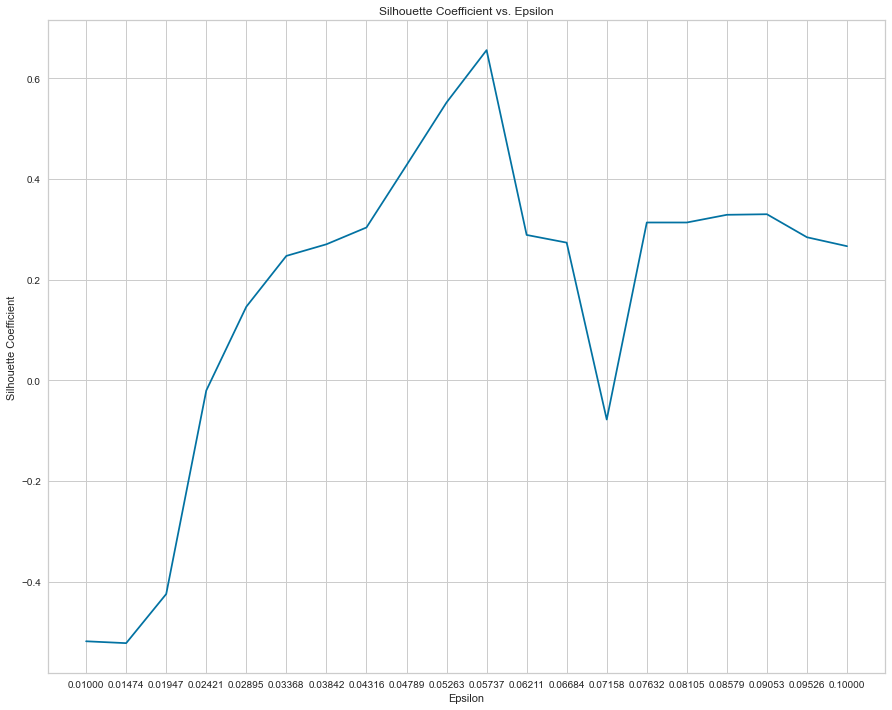

In [55]:
X_sampled = X_scaled[np.random.choice(X_scaled.shape[0], 10000, replace=False), :]

sc_scores = []
eps_range = np.linspace(0.01, 0.1, 20)

for eps in eps_range:
    dbscan = DBSCAN(
        eps=eps, min_samples=2 * X_sampled.shape[1], metric="euclidean", n_jobs=-1
    )  # Choose the two times the number of features as the minimum number of samples
    dbscan.fit(X_sampled)
    sc_scores.append(silhouette_score(X_sampled, dbscan.labels_))

plt.plot(eps_range, sc_scores)
plt.xlabel("Epsilon")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Coefficient vs. Epsilon")
plt.xticks(eps_range)
plt.show();

A few runs of the for loop above shows that a good candidate for $\epsilon$ is around $0.05$.

In [56]:
dbscan = DBSCAN(
    eps=0.05, min_samples=2 * X_sampled.shape[1], metric="euclidean", n_jobs=-1
)

labels_dbscan = dbscan.fit_predict(X_sampled)

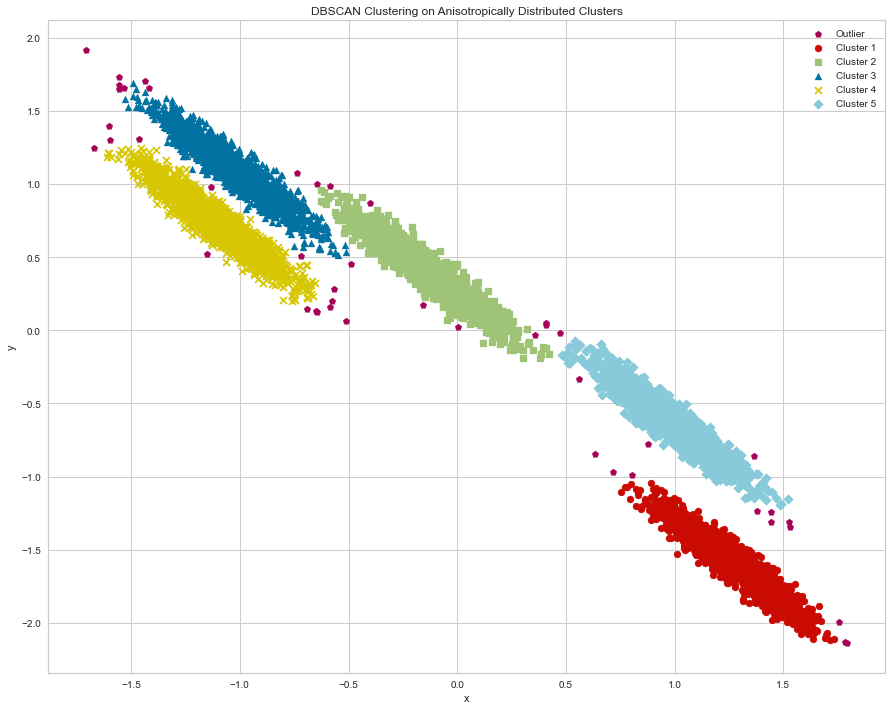

In [61]:
# Data for plotting
x = X_sampled[:, 0]
y = X_sampled[:, 1]
c_dbscan = labels_dbscan

# Define a color map and markers for each cluster
colors = ["r", "g", "b", "y", "c", "m"]
markers = ["o", "s", "^", "x", "D", "p"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_dbscan):
    mask = c_dbscan == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("x")
plt.ylabel("y")
plt.title("DBSCAN Clustering on Anisotropically Distributed Clusters")
plt.legend(["Outlier", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5"])
plt.show()

### HDBSCAN

The hierarchical DBSCAN performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. This implementation is much faster than that of scikit-learn. In addition, it allows us to tune just one of the two hyperparameters of the clustering algorithm, and thus simplifying the tuning task. 

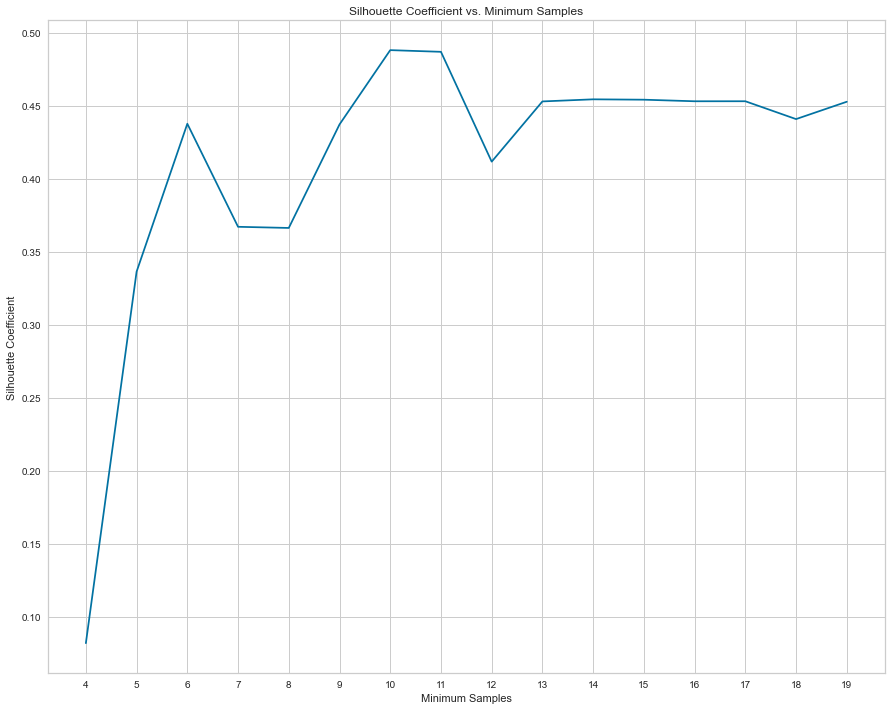

In [110]:
sc_scores = []
min_samples_range = np.arange(4, 20)

for min_samples in min_samples_range:
    hdbscan = HDBSCAN(min_samples=min_samples, metric="euclidean")
    hdbscan.fit(X_sampled)
    sc_scores.append(silhouette_score(X_sampled, hdbscan.labels_))

plt.plot(min_samples_range, sc_scores)
plt.xlabel("Minimum Samples")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Coefficient vs. Minimum Samples")
plt.xticks(min_samples_range)
plt.show();

From the plot above, it appears that `min_samples=10` returned the highest silhouette coefficient:

In [112]:
hdbscan = HDBSCAN(min_samples=10, metric="euclidean")

hdbscan_labels = hdbscan.fit_predict(X_sampled)

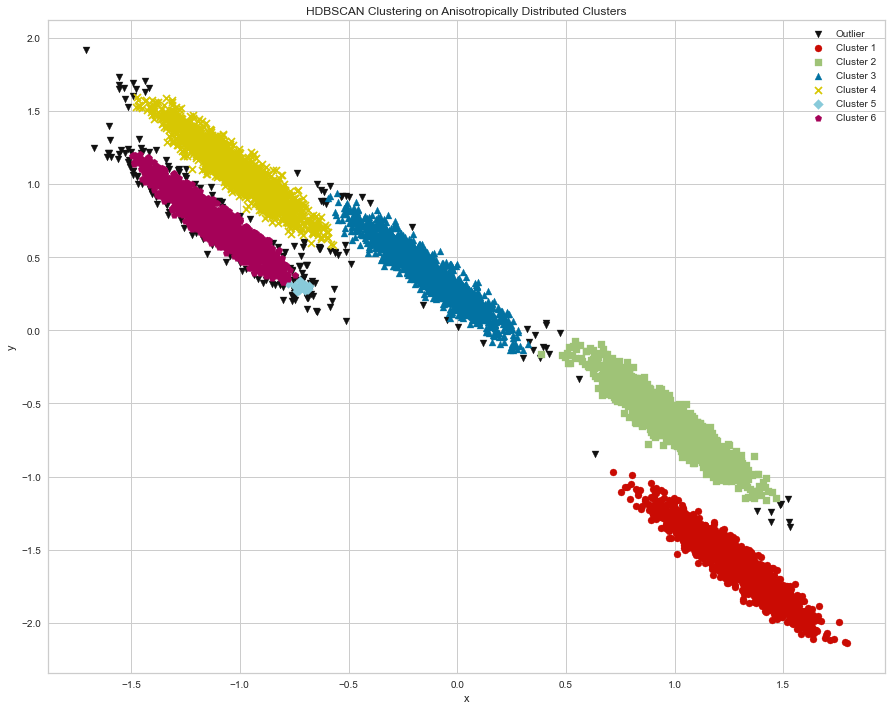

In [114]:
# Data for plotting
x = X_sampled[:, 0]
y = X_sampled[:, 1]
c_hdbscan = hdbscan_labels

# Define a color map and markers for each cluster
colors = ["r", "g", "b", "y", "c", "m", "k"]
markers = ["o", "s", "^", "x", "D", "p", "v"]

# Create the scatter plot
fig, ax = plt.subplots()
for c in np.unique(c_hdbscan):
    mask = c_hdbscan == c
    ax.scatter(x[mask], y[mask], c=colors[c], marker=markers[c])

# Add axis labels and show the plot
plt.xlabel("x")
plt.ylabel("y")
plt.title("HDBSCAN Clustering on Anisotropically Distributed Clusters")
plt.legend(
    [
        "Outlier",
        "Cluster 1",
        "Cluster 2",
        "Cluster 3",
        "Cluster 4",
        "Cluster 5",
        "Cluster 6",
    ]
)
plt.show()

### Choosing Epsilon Using K-Distance Graph

In DBSCAN, the $\epsilon$ parameter determines the maximum distance between two points for them to be considered as part of the same cluster. If $\epsilon$ is set to a small value, then only points that are very close to each other will be considered as part of the same cluster. If epsilon is set to a larger value, then more points will be considered as part of the same cluster.

* Let $d$ be the distance of a training example $x_{i}$ to its k-th nearest neighbor, then the d-neighborhood of $x_{i}$ contains exactly $k + 1$ training examples for almost all training examples $x_{i}$ for $i \in 1, ..., n$. 
* For a given k, we define a function k-dist that maps each training example $x_{i}$ (an n-dimensional vector) to the distance from its k-th nearest neighbor (a real number). When sorting all training example of the data in descending order in terms of their k-dist values (i.e. their distances to its k-th nearest neighbor), the graph of this function gives some hints concerning the density distribution in the data.

The k-distance graph captures the sudden increase in distance by plotting the distance to the k-nearest neighbors on the y-axis and the rank of the point on the x-axis. This can help identify the "elbow" point, which represents the point where the distance to the k-nearest neighbor suddenly increases, and it corresponds to the natural clustering of the data. The epsilon value can be chosen as the distance at the elbow point (y-value), since this distance can be interpreted as the maximum distance between two training examples for them to be considered as part of the same cluster. It follows that if two training examples have a distance that is greater than this maximal distance at the elbow point, then they should be considered as belonging to separate clusters.

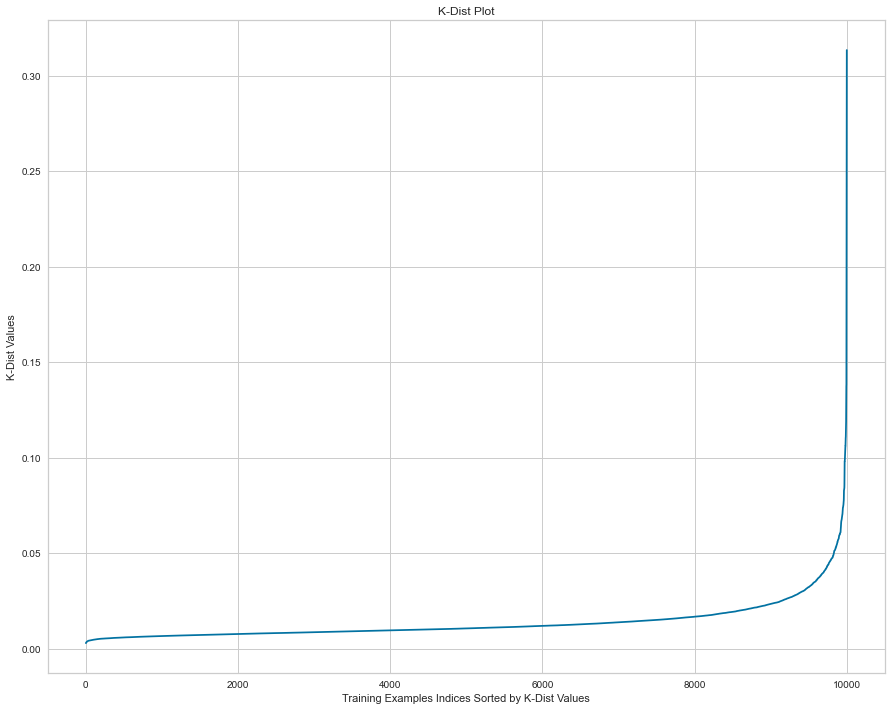

In [133]:
nbrs = NearestNeighbors(n_neighbors=5 + 1).fit(X_sampled)
distances, indices = nbrs.kneighbors(X_sampled)
k_distances = distances[:, -1]
k_distances = np.sort(k_distances)
plt.plot(range(len(k_distances)), k_distances)
plt.title("K-Dist Plot")
plt.ylabel("K-Dist Values")
plt.xlabel("Training Examples Indices Sorted by K-Dist Values")
plt.show();

Based on this visualization, the largest increase in k-dist (a training example's distance to its fifth nearest neighborhood) occurs around $0.05$, which corroborates with the conclusion drawn from the Silhouette Coefficient. 

### Results for DBSCAN

As can be seen, the DBSCAN algorithms performed much better than the K-means algorithm for anisotropically distributed data. One of the main advantages of DBSCAN is that it does not require the number of clusters to be specified in advance, unlike centroid-based algorithms such as k-means. Additionally, DBSCAN can find clusters with non-uniform shapes and sizes, which is beneficial when working with anisotropically distributed data. However, care must be taken when tuning the parameters `minPt` and `eps`.